In [50]:
import torch
import gym
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import random

In [51]:
class ActorNet(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(ActorNet,self).__init__()
        self.fc1 = nn.Linear(input_dim,64)
        self.elu1 = nn.Tanh()
        self.fc2 = nn.Linear(64,64)
        self.elu2 = nn.Tanh()
        self.fc3 = nn.Linear(64,output_dim)
        
    def forward(self,obj,action=False,max_act=False):
        x = torch.FloatTensor(obj)
        x = self.elu1(self.fc1(x))
        x = self.elu2(self.fc2(x))
        logits = self.fc3(x)
        m = Categorical(logits=logits)
        act = m.sample()
        log_p = m.log_prob(act)
        if action:
            return m.log_prob(torch.LongTensor(action))
        else:
            if max_act:
                return torch.argmax(logits).item()
            else:
                return m,act.item(),log_p

In [52]:
env = gym.make('Acrobot-v1')

In [53]:
input_dim = env.observation_space.shape[0]

In [54]:
output_dim = env.action_space.n

In [55]:
act_net = ActorNet(input_dim,output_dim)

In [56]:
# obj = env.reset()
# done = False
# while not done:
#     m,act,log_p = act_net.forward(obj)
#     next_obj,reward,done,_ = env.step(act)
#     env.render()
# env.close()

In [57]:
class CriticNet(nn.Module):
    def __init__(self,input_dim):
        super(CriticNet,self).__init__()
        self.fc1 = nn.Linear(input_dim,64)
        self.elu1 = nn.Tanh()
        self.fc2 = nn.Linear(64,64)
        self.elu2 = nn.Tanh()
        self.fc3 = nn.Linear(64,1)
        
    def forward(self,obj):
        x = torch.FloatTensor(obj)
        x = self.elu1(self.fc1(x))
        x = self.elu2(self.fc2(x))
        v = self.fc3(x)
        return v

In [58]:
crit_net = CriticNet(input_dim)

In [59]:
gamma = 0.99
lamda = 0.95
clip_ratio = 0.2
lr_pi = 1e-4
lr_v = 1e-3
target_kl = 0.01
train_pi_iter = 5
train_v_iter = 5

In [60]:
optim_actor = optim.Adam(params=act_net.parameters(),lr=lr_pi)
optim_critic = optim.Adam(params=crit_net.parameters(),lr=lr_v)

In [61]:
def disc_cuml_rew_calc(rews,gamma=gamma):
#     rews_disc = [rews[i]*gamma**i for i in range(len(rews))]
#     rews_disc_rev = rews_disc.copy()
#     rews_disc_rev.reverse()
#     rews_disc_rev_cuml = [reduce(lambda a,b: a+b,rews_disc_rev[:i+1]) for i in range(len(rews_disc_rev))]
#     rews_disc_rev_cuml.reverse()
    return list(scipy.signal.lfilter([1], [1, float(-gamma)], rews[::-1], axis=0)[::-1])
#     rews_disc_cuml = np.array(rews_disc_rev_cuml)
#     rews_disc_cuml_scaled = (rews_disc_cuml - rews_disc_cuml.min())/(rews_disc_cuml.max() - rews_disc_cuml.min())
#     return rews_disc_rev_cuml

In [62]:
# traj_n = 500
# trajectories = []
# ten_traj = 0
# ten_v = 0
# for t in range(traj_n):
#     traj = []
#     rews = []
#     obj = env.reset()
#     done = False
#     while not done:
#         v = crit_net(obj)
#         m,act,log_p = act_net.forward(obj)
#         next_obj,reward,done,_ = env.step(act)
#         traj.append([act,obj,next_obj,reward,done,log_p,v])
#         rews.append(reward)
#         obj = next_obj
#         if t % 10 == 0:
#             env.render()
#     if t % 10 == 0:
#         print(t)
#         env.close()
#     rews_disc_cuml_scaled = disc_cuml_rew_calc(rews)
#     traj = [i + [j] for i,j in zip(traj,rews_disc_cuml_scaled)]
#     trajectories.append(traj)
#     act,obj,_,rews,_,old_policy,v,rews_disc_cuml = zip(*traj)
#     old_policy = torch.FloatTensor(old_policy)

#     new_policy = act_net.forward(obj,action=act)
#     ratio = torch.exp(new_policy-old_policy)
#     adv = [rews[i] + gamma*v[i+1] - v[i] for i in range(len(rews)-1)] + [0 - v[-1]]
#     adv = torch.FloatTensor(adv)
#     adv = disc_cuml_rew_calc(adv.numpy(),gamma*lamda)
#     adv = torch.FloatTensor(adv)
#     adv = (adv - adv.mean())/adv.std()
#     clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
#     loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()
#     ten_traj+=loss_pi
#     loss_v = ((crit_net.forward(obj) - torch.FloatTensor(rews_disc_cuml)) ** 2).mean()
#     ten_v+=loss_v
#     if t % 10 == 0:
#         print('training')
# #         ten_traj = torch.FloatTensor(ten_traj)
# #         ten_traj = ten_traj.mean()
# #         ten_traj.requires_grad = True
# #         ten_v = torch.FloatTensor(ten_v)
# #         ten_v = ten_v.mean()
# #         ten_v.requires_grad = True
#         ten_traj /= 10
#         ten_v /= 10
#         for t in range(train_pi_iter):
#             optim_actor.zero_grad()
#             ten_traj.backward()
#             optim_actor.step()
#             if (new_policy - old_policy).mean().item() > 1.5 * target_kl:
#                 print('early_stopping')
#                 break
#             for j in range(10):
#                 new_policy = act_net.forward(obj,action=act)
#                 ratio = torch.exp(new_policy-old_policy)
#                 adv = [rews[i] + gamma*v[i+1] - v[i] for i in range(len(rews)-1)] + [0 - v[-1]]
#                 adv = torch.FloatTensor(adv)
#                 adv = disc_cuml_rew_calc(adv.numpy(),gamma*lamda)
#                 adv = torch.FloatTensor(adv)
#                 adv = (adv - adv.mean())/adv.std()
#                 clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
#                 loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()
#                 ten_traj+=loss_pi
#             ten_traj /= 10
            
#         for t in range(train_v_iter):
#             optim_critic.zero_grad()
#             ten_v.backward()
#             optim_critic.step()
#             for j in range(10):
#                 loss_v = ((crit_net.forward(obj) - torch.FloatTensor(rews_disc_cuml)) ** 2).mean()
#                 ten_v+=loss_v
#             ten_v /= 10
            
#         ten_traj = 0
#         ten_v = 0

In [63]:
def reward_sense(randomness,rewards,noise,certainity):
    if len(rewards) >= 2:
        rew_last = rewards[-2]
        rew_curr = rewards[-1]
        if sum(rew_last) < sum(rew_curr):
            randomness *= certainity
        return randomness
    else:
        return randomness

In [64]:
traj_n = 1000
trajectories = []
# randomness = 1.0
# certainity = 0.97
# noise = 1.03
# lowest_randomness = 0.05
rewards = []
for t in range(traj_n):
    traj = []
    rews = []
    obj = env.reset()
    done = False
    while not done:
        v = crit_net(obj)
        m,act,log_p = act_net.forward(obj)
#         if randomness > random.random():
#             act = random.choice(range(env.action_space.n))
        next_obj,reward,done,_ = env.step(act)
        traj.append([act,obj,next_obj,reward,done,log_p,v])
        rews.append(reward)
        obj = next_obj
#         if t % 10 == 0:
#             env.render()
    if t % 100 == 0:
        print(t)
#         env.close()
    rews_disc_cuml_scaled = disc_cuml_rew_calc(rews)
    rewards.append(rews)
    traj = [i + [j] for i,j in zip(traj,rews_disc_cuml_scaled)]
    trajectories.append(traj)
    act,obj,_,rews,_,old_policy,v,rews_disc_cuml = zip(*traj)
    old_policy = torch.FloatTensor(old_policy)
    for t in range(train_pi_iter):
        new_policy = act_net.forward(obj,action=act)
        ratio = torch.exp(new_policy-old_policy)
        adv = [rews[i] + gamma*v[i+1] - v[i] for i in range(len(rews)-1)] + [0 - v[-1]]
        adv = torch.FloatTensor(adv)
        adv = disc_cuml_rew_calc(adv.numpy(),gamma*lamda)
        adv = torch.FloatTensor(adv)
        adv = (adv - adv.mean())/adv.std()
        clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()
        optim_actor.zero_grad()
        loss_pi.backward()
        optim_actor.step()
        if (new_policy - old_policy).mean().item() > 1.5 * target_kl:
            print('early_stopping')
            break
    for t in range(train_v_iter):
        loss_v = ((crit_net.forward(obj) - torch.FloatTensor(rews_disc_cuml)) ** 2).mean()
        optim_critic.zero_grad()
        loss_v.backward()
        optim_critic.step()
#     if randomness >= lowest_randomness:
#         randomness = reward_sense(randomness,rewards,noise,certainity)
#     print('rews_sum',sum(rewards[-1]))
#     print('randomness',randomness)

0


KeyboardInterrupt: 

In [65]:
crit_net(obj)

tensor([-1.4587], grad_fn=<AddBackward0>)

In [66]:
crit_net.forward(obj)

tensor([-1.4587], grad_fn=<AddBackward0>)

In [36]:
episode_returns = [sum([i[3] for i in t]) for t in trajectories]

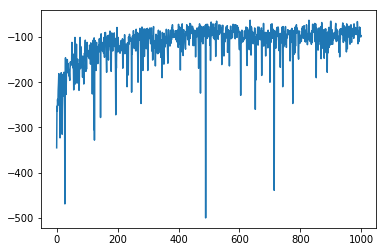

In [37]:
plt.plot(episode_returns)

In [49]:
done = False
obj = env.reset()
rw = 0
while not done:
    act = act_net.forward(obj,max_act=True)
    obj,reward,done,_ = env.step(act)
    rw += reward
    env.render()
env.close()
print(rw)

-74.0


In [73]:
m.logits.argmax().item()

tensor(3)

In [82]:
# torch.save(act_net,'ppo_cartpole')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ActorNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
gamma = 0.99
lamda = 0.95
clip_ratio = 0.2
lr = 1e-3
target_kl = 0.01
train_pi_iter = 80
train_v_iter = 80